# Plotting PyPSA results (simplified version 4-nodes clustering and 1 year data - Bolivia)

In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [38]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-4H.nc"

base_network= os.getcwd() +  "/networks/base.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_base= pypsa.Network(base_network)

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-4H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Base network

In [39]:
n_base

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 104
 - Line: 88
 - Transformer: 22
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x295c0160190>,
 <matplotlib.collections.LineCollection at 0x295c14d0fd0>)

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


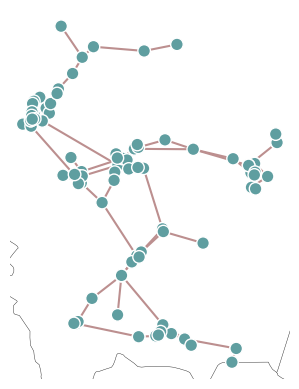

In [41]:
n_base.plot()

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


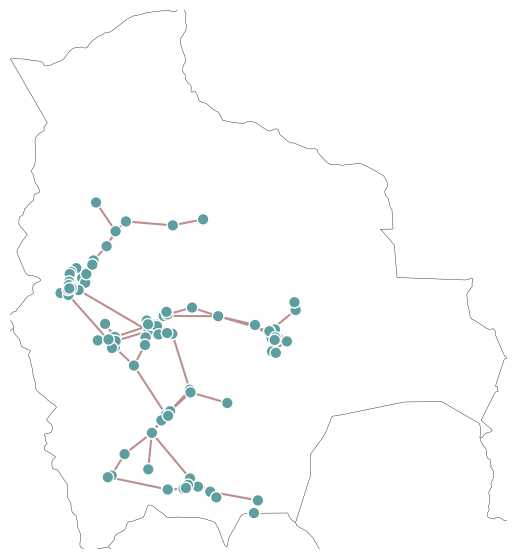

In [45]:
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import cartopy.crs as ccrs

#countries = ["Bolivia"]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n_base.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# Solved network

In [43]:
n = n_solve
n

PyPSA Network
Components:
 - Bus: 15
 - Carrier: 16
 - Generator: 15
 - GlobalConstraint: 1
 - Line: 3
 - Link: 20
 - Load: 5
 - Store: 10
Snapshots: 2190

In [6]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,type,investment_period,carrier_attribute,mu
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,primary_energy,NaN,co2_emissions,0.0


In [7]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)


n.objective

662043683.0018111

### Spatial temporal resolution

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


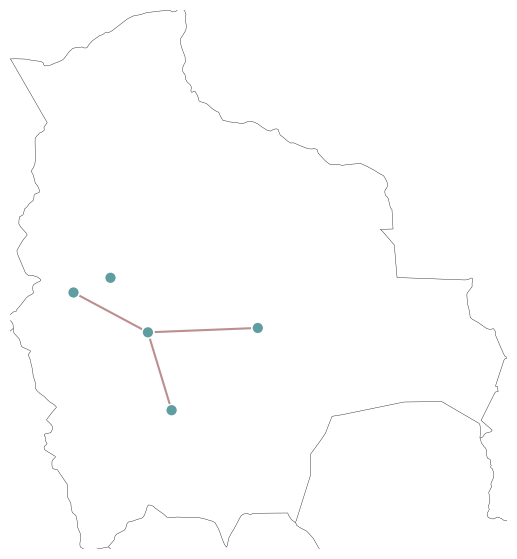

In [44]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [9]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (4h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

2190

### Overview components

In [11]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 15 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 3 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 20 entries
Component 'Load' has 5 entries
Component 'Generator' has 15 entries
Component 'Store' has 10 entries


### Energy balance

In [12]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO0 0 H2         0.000000e+00
BO0 1 H2         3.552714e-15
BO0 2 H2         0.000000e+00
BO0 3 H2        -7.105427e-15
BO1 0 H2        -1.136868e-13
BO0 0 battery    7.993606e-15
BO0 1 battery    1.332268e-15
BO0 2 battery   -1.591616e-12
BO0 3 battery    1.023182e-12
BO1 0 battery    6.821210e-13
dtype: float64

In [46]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 

n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators.head()

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'p_nom_min',
       'marginal_cost', 'carrier', 'p_nom_extendable', 'bus', 'control',
       'p_nom_opt', 'sign', 'build_year', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'type', 'p_min_pu', 'p_max_pu',
       'p_set', 'q_set', 'lifetime', 'efficiency', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,efficiency,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO0 0 onwind,622421.095097,71313.090943,11.443179,96085.888020,11.443179,0.025955,onwind,True,BO0 0,Slack,11.456011,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 solar,239190.211816,33571.852100,11.995317,35602.071244,11.995317,0.019411,solar,True,BO0 0,,12.011843,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 onwind,260939.164992,11388.227236,1.565017,96085.888020,1.565017,0.024339,onwind,True,BO0 1,,1.566295,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 solar,361752.146638,71573.369786,25.844448,35602.071244,25.844448,0.019267,solar,True,BO0 1,,25.930327,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 2 onwind,100134.117279,2383.248244,0.321457,96085.888020,0.321457,0.024099,onwind,True,BO0 2,,0.323638,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0


In [47]:
#Imprimir solo los generadores de Bolivia

########this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].head()

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,efficiency,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO0 0 onwind,622421.095097,71313.090943,11.443179,96085.888020,11.443179,0.025955,onwind,True,BO0 0,Slack,11.456011,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 solar,239190.211816,33571.852100,11.995317,35602.071244,11.995317,0.019411,solar,True,BO0 0,,12.011843,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 onwind,260939.164992,11388.227236,1.565017,96085.888020,1.565017,0.024339,onwind,True,BO0 1,,1.566295,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 solar,361752.146638,71573.369786,25.844448,35602.071244,25.844448,0.019267,solar,True,BO0 1,,25.930327,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 2 onwind,100134.117279,2383.248244,0.321457,96085.888020,0.321457,0.024099,onwind,True,BO0 2,,0.323638,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0


In [50]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

####### Data was not yet updated and therefore a big difference between real capacities in 2020 (largely oversized) and optimized installed capacities (relatively low changes)
# - To change this, additional plants have to be added to better represent the system

idx = ['BO' in x for x in n.generators.index]

print(n.generators.loc[idx,:].p_nom.sum())
print(n.generators.loc[idx,:].p_nom_opt.sum())

5000000144.86887
5000010139.280518


In [51]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


7443065.770083291

### Total installed generator capacity

In [52]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.to_csv('capacities_by_carrier.csv',index=False)
gen_cap


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3784\3296247162.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,efficiency,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
load,NaN,0.000000,5.000000e+09,0.000000,0.000000,5.051019,0,5.000000e+09,0.005,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,5.0,0,0.0,0.0,0.0,0.0,5.0,5.0
onwind,2.371526e+06,160226.734509,2.591088e+01,480429.440100,25.910879,0.124632,5,2.594480e+01,5.000,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,5.0,0,0.0,0.0,0.0,0.0,5.0,5.0
solar,1.862944e+06,329520.899006,1.189580e+02,178010.356219,118.957991,0.099010,5,1.011334e+04,5.000,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,5.0,0,0.0,0.0,0.0,0.0,5.0,5.0


In [18]:
n.stores_t.p.head()

Store,BO0 0 H2,BO0 1 H2,BO0 2 H2,BO0 3 H2,BO1 0 H2,BO0 0 battery,BO0 1 battery,BO0 2 battery,BO0 3 battery,BO1 0 battery
snapshot,,,,,,,,,,
2013-01-01 00:00:00,-0.181026,-0.167193,-0.008608,-0.205427,-13.042346,0.025488,-0.016958,671.895180,362.935244,387.242364
2013-01-01 04:00:00,-0.173827,-0.115720,-0.012954,-0.209221,-12.938368,-0.082407,-0.140535,636.473549,158.592232,302.321854
2013-01-01 08:00:00,-0.174073,-0.162515,-0.013972,-0.228530,-13.115131,0.065741,0.007287,643.121353,211.383222,323.710773
2013-01-01 12:00:00,-0.249858,-0.309711,-0.029470,-0.398738,-18.073905,-0.106596,-0.180402,-775.036768,-340.019252,-462.080975
2013-01-01 16:00:00,-0.275778,-0.283401,-0.031499,-0.336374,-17.969750,-0.081179,0.187018,-1247.411634,-438.576014,-537.049514


<AxesSubplot:xlabel='snapshot'>

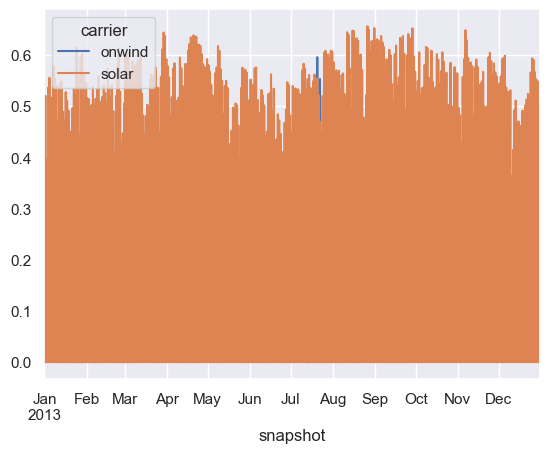

In [19]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [20]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [21]:
n.loads_t.p.sum().sum()

2827084.0334878056

In [22]:
n.generators_t.p.sum().sum()

10270149.803571098

In [23]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus    carrier
BO0 0  load       3.000000e+02
       onwind     3.432954e-06
       solar      3.598595e-06
BO0 1  load       3.000000e+02
       onwind     4.695050e-07
       solar      7.753334e-06
BO0 2  load       3.000000e+02
       onwind     9.643716e-08
       solar      2.536303e-06
BO0 3  load       3.000000e+02
       onwind     2.214481e-06
       solar      1.504863e-05
BO1 0  load       3.000000e+02
       onwind     1.559886e-06
       solar      6.750535e-06
Name: p_nom, dtype: float64

### Demand

In [25]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO0 0    1.000000e+09
BO0 1    1.000000e+09
BO0 2    1.000004e+09
BO0 3    1.000002e+09
BO1 0    1.000004e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

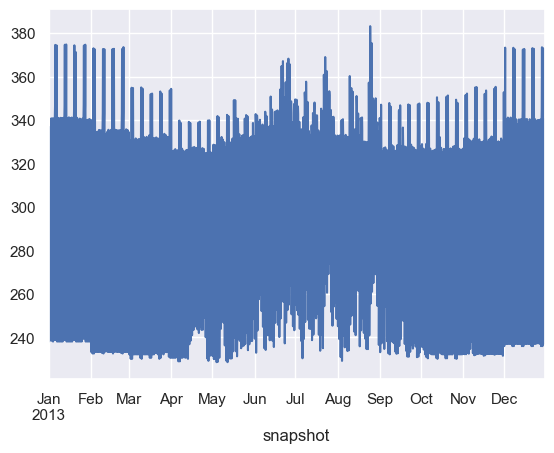

In [37]:
n.loads_t.p_set.loc["2013-01-01":"2013-12-30","BO0 0"].plot()

Load
BO0 0    657693.143243
BO0 1    522035.944584
BO0 2    205437.164978
BO0 3    703545.887359
BO1 0    738371.893324
dtype: float64


<AxesSubplot:xlabel='Load'>

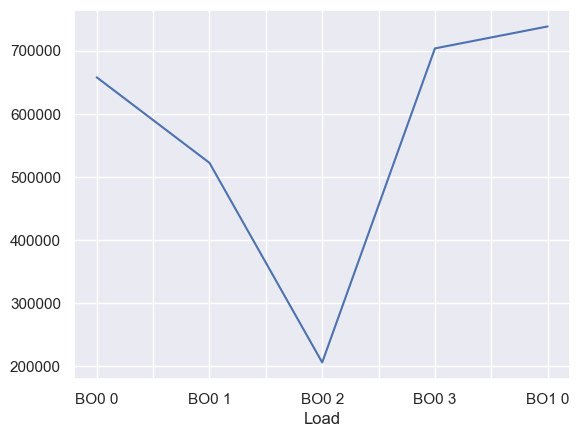

In [27]:
print(n.loads_t.p_set.sum())

n.loads_t.p_set.sum().plot()

In [28]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO0 0    657693.143243
BO0 1    522035.944584
BO0 2    205437.164978
BO0 3    703545.887359
BO1 0    738371.893324
Name: load, dtype: float64

In [29]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO0 0    1.000000e+09
BO0 1    1.000000e+09
BO0 2    1.000004e+09
BO0 3    1.000002e+09
BO1 0    1.000004e+09
Name: p_nom_opt, dtype: float64

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


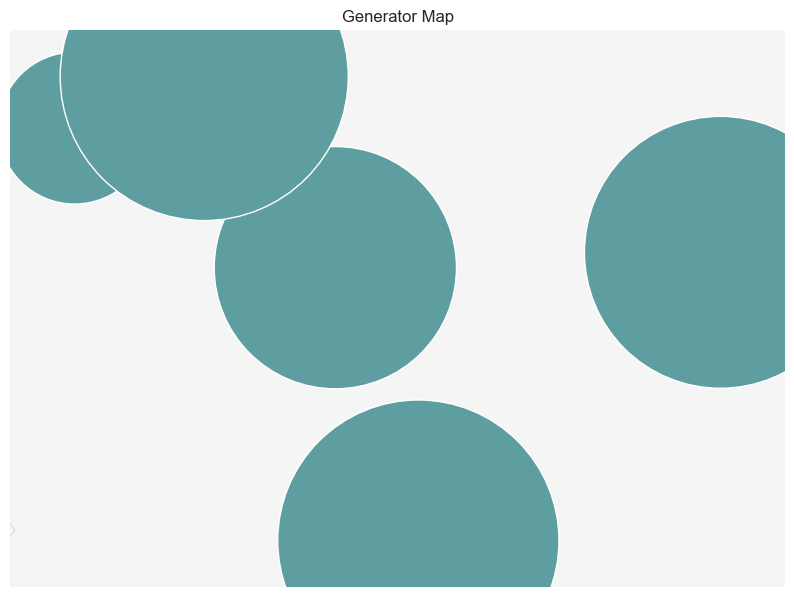

In [30]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [31]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus    carrier
BO0 0  load       1.000000e+09
       onwind     1.145601e+01
       solar      1.201184e+01
BO0 1  load       1.000000e+09
       onwind     1.566295e+00
       solar      2.593033e+01
BO0 2  load       1.000000e+09
       onwind     3.236385e-01
       solar      4.005828e+03
BO0 3  load       1.000000e+09
       onwind     7.385802e+00
       solar      2.465905e+03
BO1 0  load       1.000000e+09
       onwind     5.213058e+00
       solar      3.603661e+03
BO0 0  AC load    6.576931e+05
BO0 1  AC load    5.220359e+05
BO0 2  AC load    2.054372e+05
BO0 3  AC load    7.035459e+05
BO1 0  AC load    7.383719e+05
dtype: float64

### Plot of Average Marginal Price

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


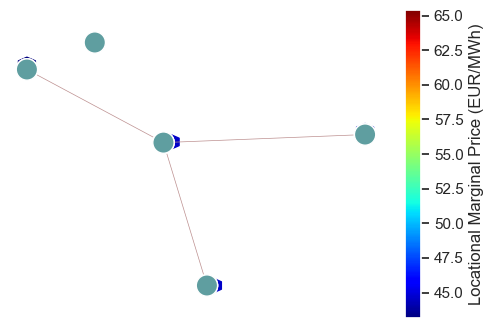

In [32]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

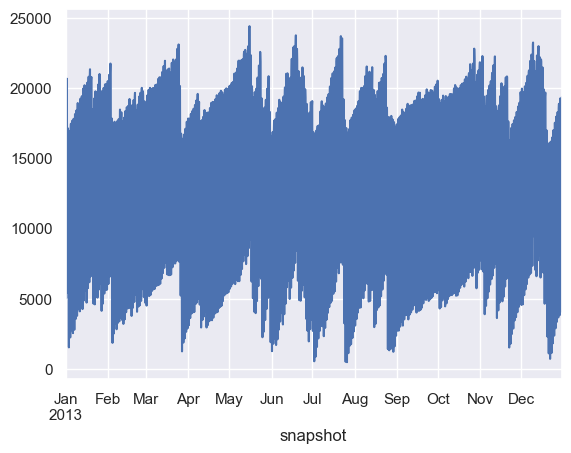

In [35]:
n.stores_t.e.loc["2013-01-01":"2013-12-30"].sum(axis=1).plot()

In [34]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis         48.793823
H2 fuel cell           131.680491
battery charger       2891.892602
battery discharger    3012.388127
Name: p_nom_opt, dtype: float64